
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [5]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
df.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


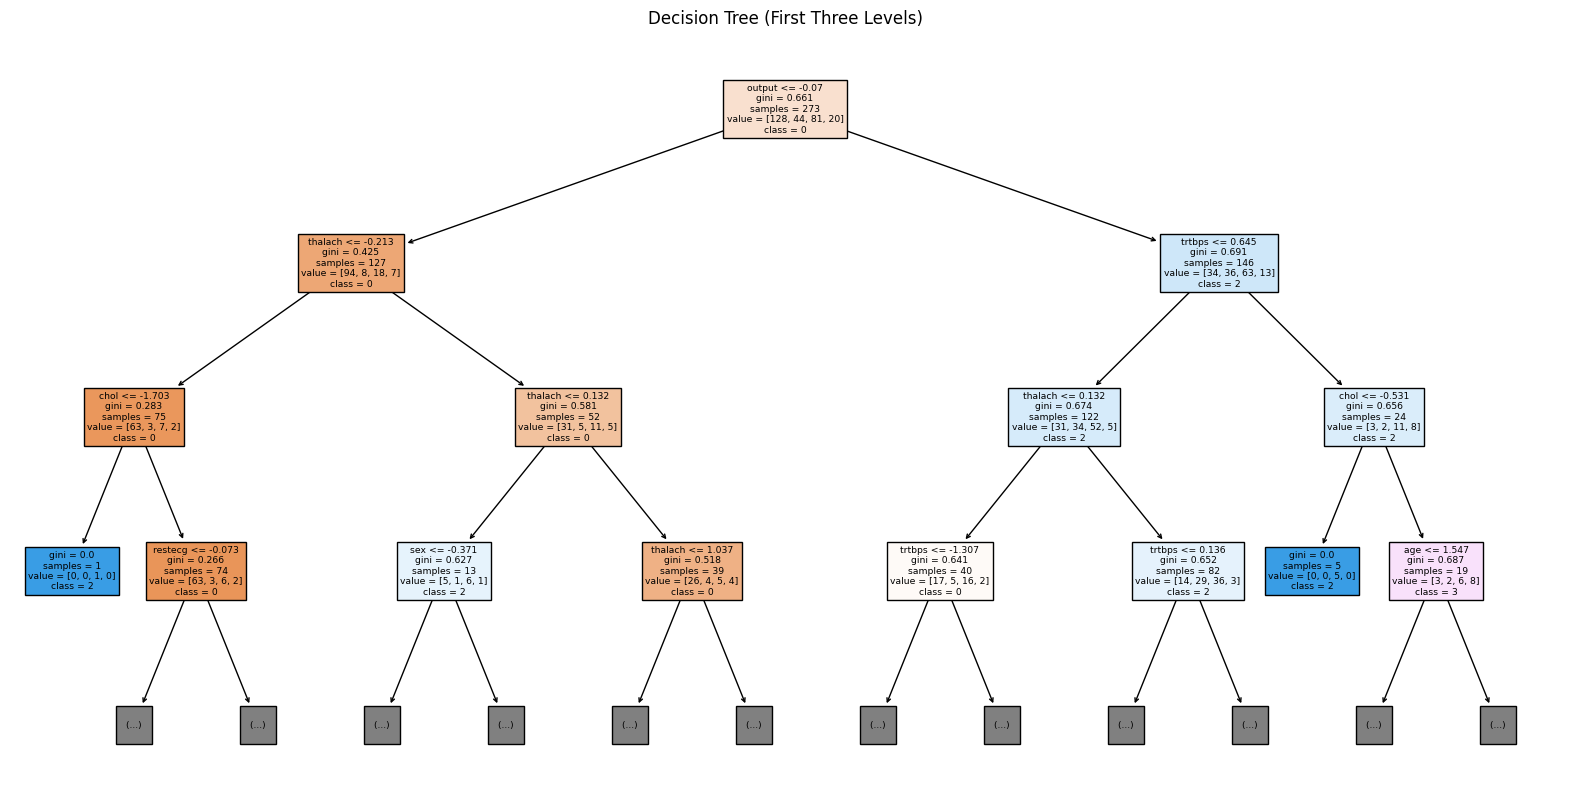

The cross-validated accuracy of the k-nearest neighbors classifier is 0.520.
The cross-validated accuracy of the Linear Discriminant Analysis classifier is 0.542.
The cross-validated accuracy of the Decision Tree classifier is 0.381.


In [12]:
y=df['cp']
X=df.drop(['cp'], axis=1)
knc_pipeline=Pipeline([
     ('scaler', StandardScaler()),
     ('knc', KNeighborsClassifier(n_neighbors=20))
])

lda_pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

accuracy_knc=cross_val_score(knc_pipeline, X, y, cv=5, scoring='accuracy').mean()
accuracy_lda=cross_val_score(lda_pipeline, X, y, cv=5, scoring='accuracy').mean()
accuracy_dt=cross_val_score(dt_pipeline, X, y, cv=5, scoring='accuracy').mean()

dt_pipeline.fit(X,y)

cp_class_names=sorted(y.unique().astype(str))

plt.figure(figsize=(20,10))
plot_tree(dt_pipeline.named_steps['dt'],
          filled=True,
          feature_names=X.columns,
          class_names=cp_class_names,
          max_depth=3)
plt.title("Decision Tree (First Three Levels)")
plt.show()

print(f"The cross-validated accuracy of the k-nearest neighbors classifier is {accuracy_knc:.3f}.")
print(f"The cross-validated accuracy of the Linear Discriminant Analysis classifier is {accuracy_lda:.3f}.")
print(f"The cross-validated accuracy of the Decision Tree classifier is {accuracy_dt:.3f}.")

The first split takes all 273 samples and splits it into 127 of class 0 and 146 samples of class 2. The first split is then split again into two that are both of class 0, while the other when splits into two that are both class 2.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [15]:
df['cp_is_3']=(df['cp']==3).astype(int)
df['cp_is_2']=(df['cp']==2).astype(int)
df['cp_is_1']=(df['cp']==1).astype(int)
df['cp_is_0']=(df['cp']==0).astype(int)

logreg_pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

y3=df['cp_is_3']
y2=df['cp_is_2']
y1=df['cp_is_1']
y0=df['cp_is_0']

f1_logreg3=cross_val_score(logreg_pipeline, X, y3, cv=5, scoring='f1_macro').mean()
f1_logreg2=cross_val_score(logreg_pipeline, X, y2, cv=5, scoring='f1_macro').mean()
f1_logreg1=cross_val_score(logreg_pipeline, X, y1, cv=5, scoring='f1_macro').mean()
f1_logreg0=cross_val_score(logreg_pipeline, X, y0, cv=5, scoring='f1_macro').mean()

f1_data={'cp value':[0,1,2,3],
         'F1 score':[f1_logreg0, f1_logreg1, f1_logreg2, f1_logreg3]
}

f1_df=pd.DataFrame(f1_data)
f1_df

,cp value,F1 score
0,0,0.665331
1,1,0.453976
2,2,0.416049
3,3,0.479979


The cp value of 0 or asymptomatic, was best distinguished by the model.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [18]:
df_reduced01=df[df['cp'].isin([0,1])]
df_reduced02=df[df['cp'].isin([0,2])]
df_reduced03=df[df['cp'].isin([0,3])]

X_reduced01=df_reduced01.drop(['cp', 'cp_is_3', 'cp_is_2', 'cp_is_1', 'cp_is_0'], axis=1)
y_reduced01=df_reduced01['cp']

X_reduced02=df_reduced02.drop(['cp', 'cp_is_3', 'cp_is_2', 'cp_is_1', 'cp_is_0'], axis=1)
y_reduced02=df_reduced02['cp']

X_reduced03=df_reduced03.drop(['cp', 'cp_is_3', 'cp_is_2', 'cp_is_1', 'cp_is_0'], axis=1)
y_reduced03=df_reduced03['cp']

roc_auc01=cross_val_score(logreg_pipeline, X_reduced01, y_reduced01, cv=5, scoring='roc_auc_ovo').mean()
roc_auc02=cross_val_score(logreg_pipeline, X_reduced02, y_reduced02, cv=5, scoring='roc_auc_ovo').mean()
roc_auc03=cross_val_score(logreg_pipeline, X_reduced03, y_reduced03, cv=5, scoring='roc_auc_ovo').mean()

data_roc={'OvO':['0v1','0v2','0v3'],
          'ROC_AUC':[roc_auc01, roc_auc02, roc_auc03]}

df_roc=pd.DataFrame(data_roc)
df_roc

,OvO,ROC_AUC
0,0v1,0.837671
1,0v2,0.751584
2,0v3,0.741231


The 0v1 pair was best distinguished by the model.